# Earth - Gravity grid at 10 arc-minute resolution

Global 10 arc-minute resolution grids of gravity acceleration (gravitational and centrifugal) at 10 km geometric height.

**Source:** [EIGEN-6C4](https://doi.org/10.5880/icgem.2015.1) spherical harmonic model (generated by the [ICGEM calculation service](http://icgem.gfz-potsdam.de/home))

**License:** [CC-BY](https://doi.org/10.5880/icgem.2015.1)

## Notes

This notebook loads the grid from the text file, sets proper CF-compliant metadata, and saves it to compressed netCDF for a smaller file size (requires the netcdf4 library for loading). Coordinates are referenced to WGS84.

In [1]:
import os
import lzma
from pathlib import Path
import xarray as xr
import numpy as np
import harmonica as hm
import pygmt
import pooch

## Read the data

Use Harmonica to read the data.

In [2]:
with lzma.open(Path("raw") / "EIGEN-6C4_gravity.gdf.xz", "rt") as f:
    data_raw = hm.load_icgem_gdf(f, dtype="float32")
icgem_metadata = data_raw.attrs.copy()
data_raw

<xarray.Dataset>
Dimensions:          (latitude: 1081, longitude: 2161)
Coordinates:
  * longitude        (longitude) float32 -180.0 -179.8 -179.7 ... 179.8 180.0
  * latitude         (latitude) float32 -90.0 -89.83 -89.67 ... 89.67 89.83 90.0
Data variables:
    gravity_ell      (latitude, longitude) float32 9.801e+05 ... 9.802e+05
    height_over_ell  (latitude, longitude) float64 1e+04 1e+04 ... 1e+04 1e+04
Attributes: (12/33)
    generating_institute:  gfz-potsdam
    generating_date:       2021/06/11
    product_type:          gravity_field
    body:                  earth
    modelname:             EIGEN-6C4
    max_used_degree:       720
    ...                    ...
    maxvalue:              9.8020189E+05 mgal
    minvalue:              9.7474860E+05 mgal
    signal_wrms:           1.5468191E+03 mgal
    grid_format:           long_lat_value
    attributes:            longitude latitude gravity_ell
    attributes_units:      deg. deg. mgal

## Set height as a coordinate and create a new grid

Height is not added as a coordinate in the loaded dataset but as a variable. Add it as a 2D coordinate so we can keep this as a `DataArray`.

In [3]:
data = xr.DataArray(
    data_raw.gravity_ell,
    coords={
        "longitude": data_raw.longitude,
        "latitude": data_raw.latitude,
        "height": data_raw.height_over_ell.astype("float32"),
    },
    dims=("latitude", "longitude"),
    name="gravity",
)
data

<xarray.DataArray 'gravity' (latitude: 1081, longitude: 2161)>
array([[980106.56, 980106.56, 980106.56, ..., 980106.56, 980106.56,
        980106.56],
       [980108.2 , 980108.2 , 980108.2 , ..., 980108.2 , 980108.2 ,
        980108.2 ],
       [980108.8 , 980108.8 , 980108.8 , ..., 980108.75, 980108.75,
        980108.8 ],
       ...,
       [980153.8 , 980153.7 , 980153.6 , ..., 980153.94, 980153.9 ,
        980153.8 ],
       [980160.44, 980160.4 , 980160.4 , ..., 980160.44, 980160.44,
        980160.44],
       [980157.56, 980157.56, 980157.56, ..., 980157.56, 980157.56,
        980157.56]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float32 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
    height     (latitude, longitude) float32 1e+04 1e+04 1e+04 ... 1e+04 1e+04

## Fix grid coordinates

Coordinates are slightly imprecise since ICGEM uses something like `np.arange` to generate them instead of `np.linspace`, which is more precise and the correct way to do it. This means that the spacing is not exactly constant, which can mess up plotting with PyGMT later on. Fix this by assigning adjusted coordinates. This shouldn't make a difference quantitatively since changes are in the order of 1e-5 or below.

In [4]:
def fix_coordinates(grid):
    """
    Replace coordinates with ones generated with np.linspace.
    """
    longitude = np.linspace(-180, 180, grid.longitude.size)
    latitude = np.linspace(-90, 90, grid.latitude.size)
    return grid.assign_coords(longitude=longitude, latitude=latitude)

In [5]:
data = fix_coordinates(data)
data

<xarray.DataArray 'gravity' (latitude: 1081, longitude: 2161)>
array([[980106.56, 980106.56, 980106.56, ..., 980106.56, 980106.56,
        980106.56],
       [980108.2 , 980108.2 , 980108.2 , ..., 980108.2 , 980108.2 ,
        980108.2 ],
       [980108.8 , 980108.8 , 980108.8 , ..., 980108.75, 980108.75,
        980108.8 ],
       ...,
       [980153.8 , 980153.7 , 980153.6 , ..., 980153.94, 980153.9 ,
        980153.8 ],
       [980160.44, 980160.4 , 980160.4 , ..., 980160.44, 980160.44,
        980160.44],
       [980157.56, 980157.56, 980157.56, ..., 980157.56, 980157.56,
        980157.56]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
    height     (latitude, longitude) float32 1e+04 1e+04 1e+04 ... 1e+04 1e+04

## Set proper metadata

Add proper metadata following CF-conventions to all `DataArrays` and the `Dataset` as a whole.

In [6]:
def minmax_round(grid, decimals):
    """
    Return the minimum and maximum values in the grid 
    rounded to *decimal* places.
    """
    vmin = np.round(grid.values.min(), decimals=decimals)
    vmax = np.round(grid.values.max(), decimals=decimals)
    return (vmin, vmax)

In [7]:
data.attrs = {
    "Conventions": "CF-1.8",
    "title": "Gravity acceleration (EIGEN-6C4) at a constant geometric height",
    "crs": "WGS84",
    "source": "Generated from the EIGEN-6C4 model by the ICGEM Calculation Service (http://icgem.gfz-potsdam.de)",
    "license": "Creative Commons Attribution 4.0 International Licence",
    "references": "https://doi.org/10.5880/icgem.2015.1",
    "long_name": "gravity acceleration",
    "description": "magnitude of the gravity acceleration vector (gravitational + centrifugal)",
    "units": "mGal",
    "actual_range": minmax_round(data, decimals=1),
    "icgem_metadata": "\n".join([f"{k}: {v}" for k,v in icgem_metadata.items()]),
}
data.longitude.attrs = {
    "long_name": "longitude",
    "standard_name": "longitude",
    "units": "degrees_east",
    "actual_range": (data.longitude.values.min(), data.longitude.values.max()),
}
data.latitude.attrs = {
    "long_name": "latitude",
    "standard_name": "latitude",
    "units": "degrees_north",
    "actual_range": (data.latitude.values.min(), data.latitude.values.max()),
}
data.height.attrs = {
    "long_name": "geometric height",
    "standard_name": "height_above_reference_ellipsoid",
    "description": "height of gravity computation points above the WGS84 ellipsoid",
    "units": "m",
    "actual_range": (data.height.values.min(), data.height.values.max()),
}
data

<xarray.DataArray 'gravity' (latitude: 1081, longitude: 2161)>
array([[980106.56, 980106.56, 980106.56, ..., 980106.56, 980106.56,
        980106.56],
       [980108.2 , 980108.2 , 980108.2 , ..., 980108.2 , 980108.2 ,
        980108.2 ],
       [980108.8 , 980108.8 , 980108.8 , ..., 980108.75, 980108.75,
        980108.8 ],
       ...,
       [980153.8 , 980153.7 , 980153.6 , ..., 980153.94, 980153.9 ,
        980153.8 ],
       [980160.44, 980160.4 , 980160.4 , ..., 980160.44, 980160.44,
        980160.44],
       [980157.56, 980157.56, 980157.56, ..., 980157.56, 980157.56,
        980157.56]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
    height     (latitude, longitude) float32 1e+04 1e+04 1e+04 ... 1e+04 1e+04
Attributes:
    Conventions:     CF-1.8
    title:           Gravity acceleration (EIGEN-6C4) at a constant geometric...
    crs:             WGS84
    source:          Generated from the EIGEN-6C4 model by the ICGEM Calculat...
    license:         Creative Commons Attribution 4.0 International Licence
    references:      https://doi.org/10.5880/icgem.2015.1
    long_name:       gravity acceleration
    description:     magnitude of the gravity acceleration vector (gravitatio...
    units:           mGal
    actual_range:    (974748.6, 980201.9)
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

## Plot the data 

Make a quick plot to make sure the data look OK. This plot will be used as a preview of the dataset.

grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


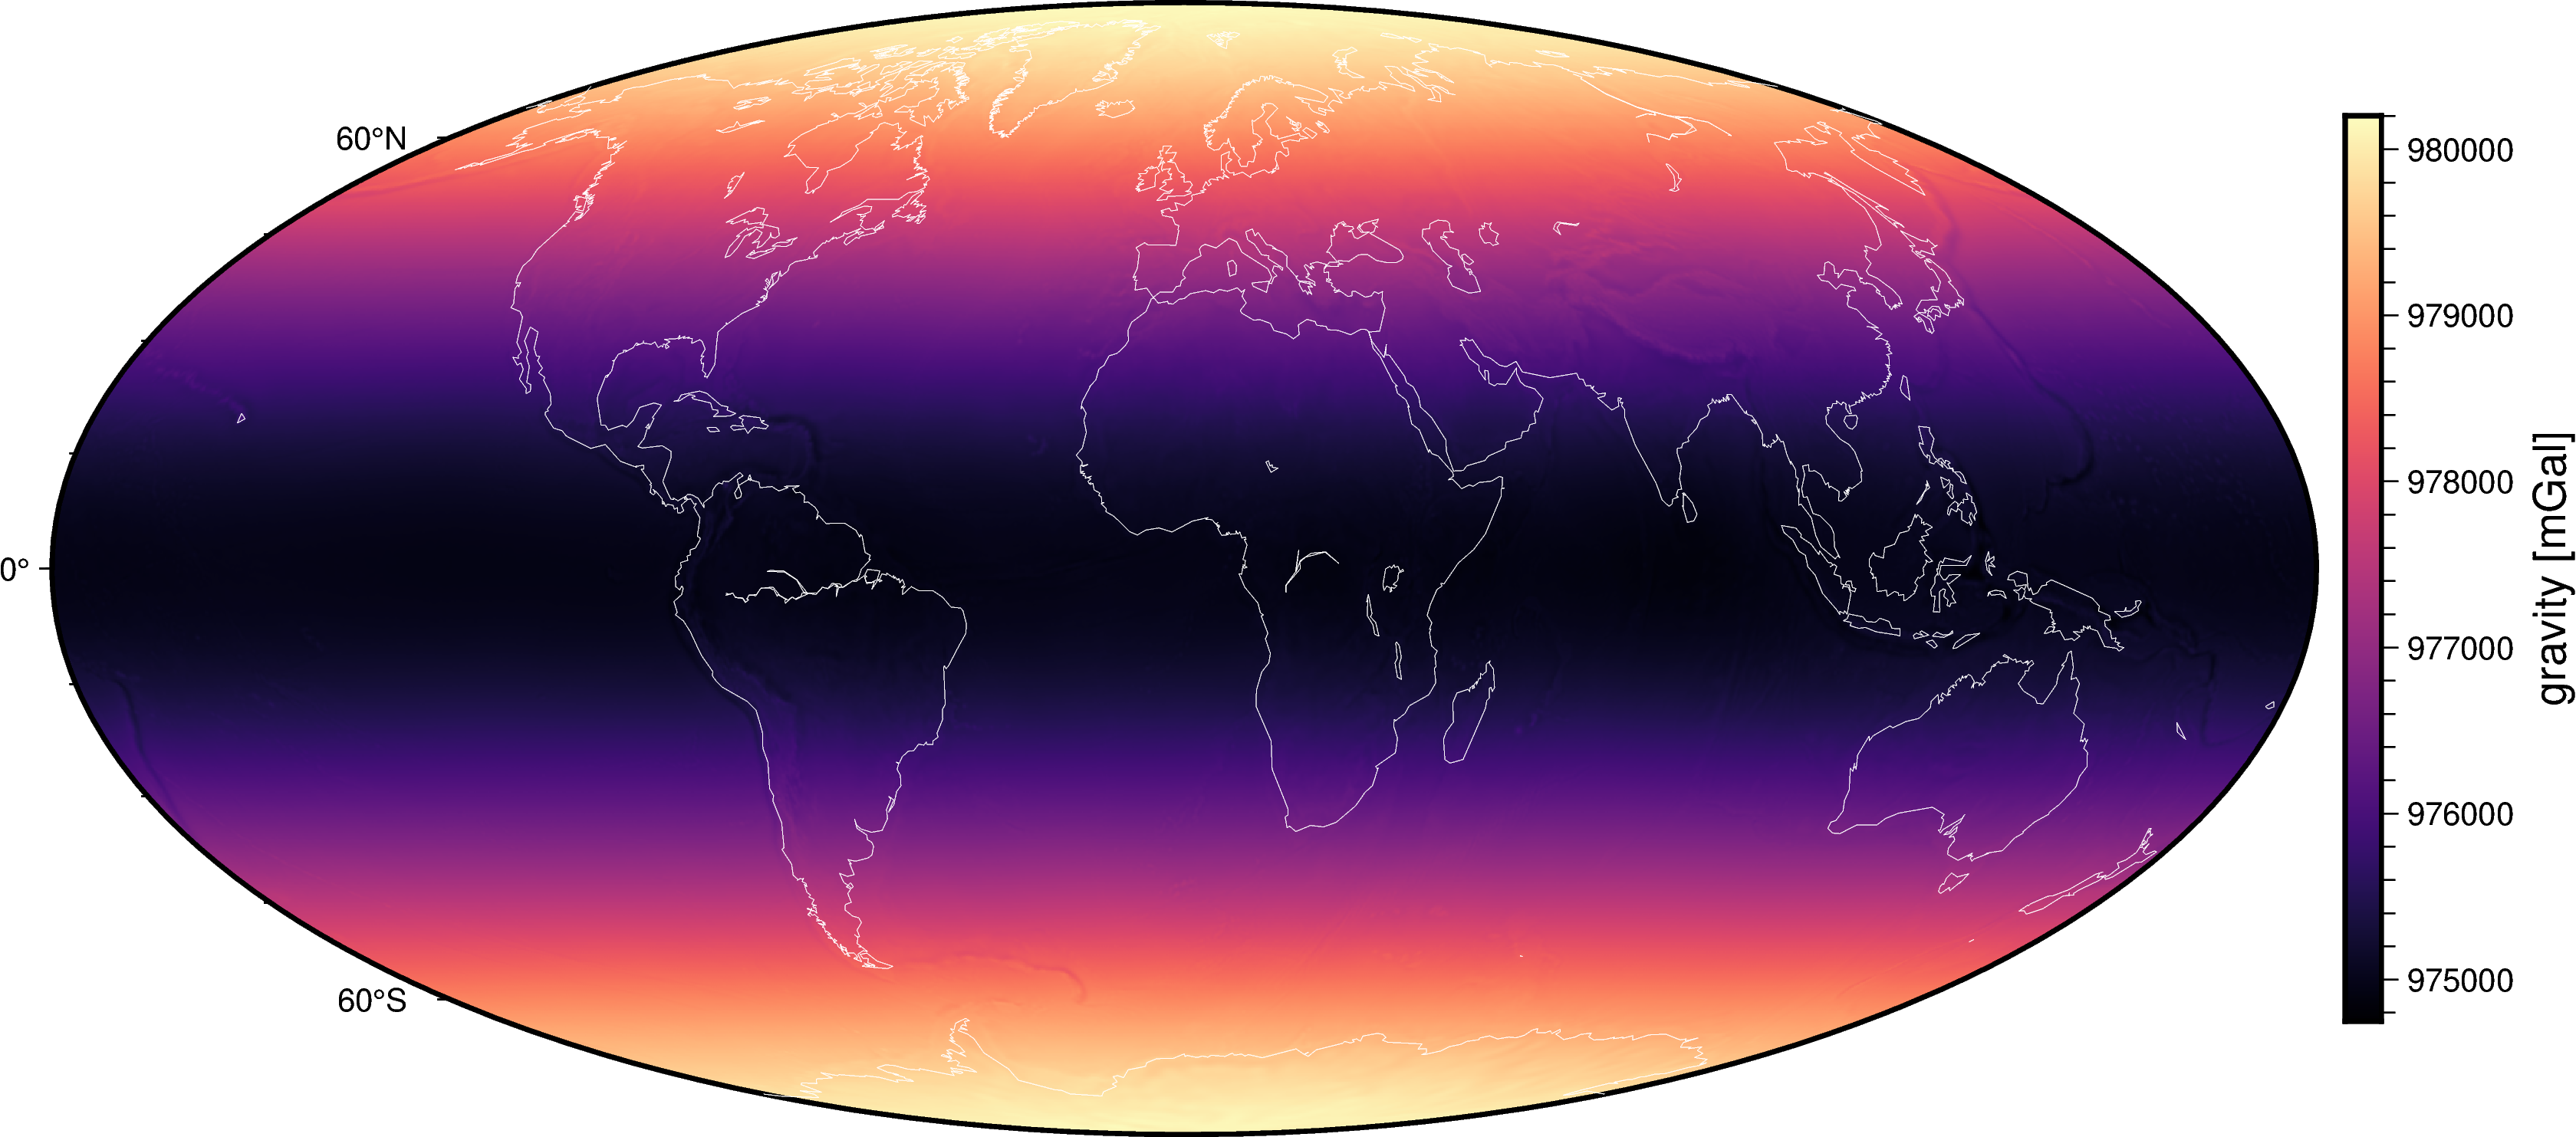

In [8]:
fig = pygmt.Figure()
fig.grdimage(data, cmap="magma", projection="W25c")
fig.colorbar(frame='af+l"gravity [mGal]"', position="JCR")
fig.basemap(frame=True)
fig.coast(shorelines="0.1p,white", area_thresh=1e4)
fig.savefig("preview.jpg", dpi=200)
fig.show()

## Export

Save the grid to a netCDF file and calculate the size and MD5/SHA256 hashes. 

Use compression (both zlib and discretization based) to reduce the file sizes. The `scale_factor` determines the amount of decimal places retained when converting floats into integers. See http://xarray.pydata.org/en/stable/user-guide/io.html#writing-encoded-data

In [9]:
output = "earth-gravity-10arcmin.nc"
data.to_netcdf(
    output, 
    format="NETCDF4",
    encoding={
        'gravity': {
            "zlib": True, 
            'dtype': 'uint16', 
            'scale_factor': 0.1, 
            '_FillValue': 65000, 
            'add_offset': np.round(data.values.min(), decimals=1),
        },
        'height': {
            "zlib": True, 
        },
    }
)
print(f"file: {output}")
print(f"size: {os.path.getsize(output) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(output, alg=alg)}")

file: earth-gravity-10arcmin.nc
size: 2.518901 Mb
md5:56df20e0e67e28ebe4739a2f0357c4a6
sha256:d55134501da0d984f318c0f92e1a15a8472176ec7babde5edfdb58855190273e


## Read back the data and plot it

Verify that the output didn't corrupt anything.

In [10]:
data_reloaded = xr.load_dataarray(output)
data_reloaded

<xarray.DataArray 'gravity' (latitude: 1081, longitude: 2161)>
array([[980106.5 , 980106.5 , 980106.5 , ..., 980106.5 , 980106.5 ,
        980106.5 ],
       [980108.25, 980108.25, 980108.25, ..., 980108.25, 980108.25,
        980108.25],
       [980108.8 , 980108.8 , 980108.8 , ..., 980108.75, 980108.75,
        980108.8 ],
       ...,
       [980153.8 , 980153.75, 980153.6 , ..., 980153.94, 980153.8 ,
        980153.8 ],
       [980160.44, 980160.44, 980160.44, ..., 980160.44, 980160.44,
        980160.44],
       [980157.5 , 980157.5 , 980157.5 , ..., 980157.5 , 980157.5 ,
        980157.5 ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
    height     (latitude, longitude) float32 1e+04 1e+04 1e+04 ... 1e+04 1e+04
Attributes:
    Conventions:     CF-1.8
    title:           Gravity acceleration (EIGEN-6C4) at a constant geometric...
    crs:             WGS84
    source:          Generated from the EIGEN-6C4 model by the ICGEM Calculat...
    license:         Creative Commons Attribution 4.0 International Licence
    references:      https://doi.org/10.5880/icgem.2015.1
    long_name:       gravity acceleration
    description:     magnitude of the gravity acceleration vector (gravitatio...
    units:           mGal
    actual_range:    [974748.6 980201.9]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

Make the figure again but don't save it to a file this time.

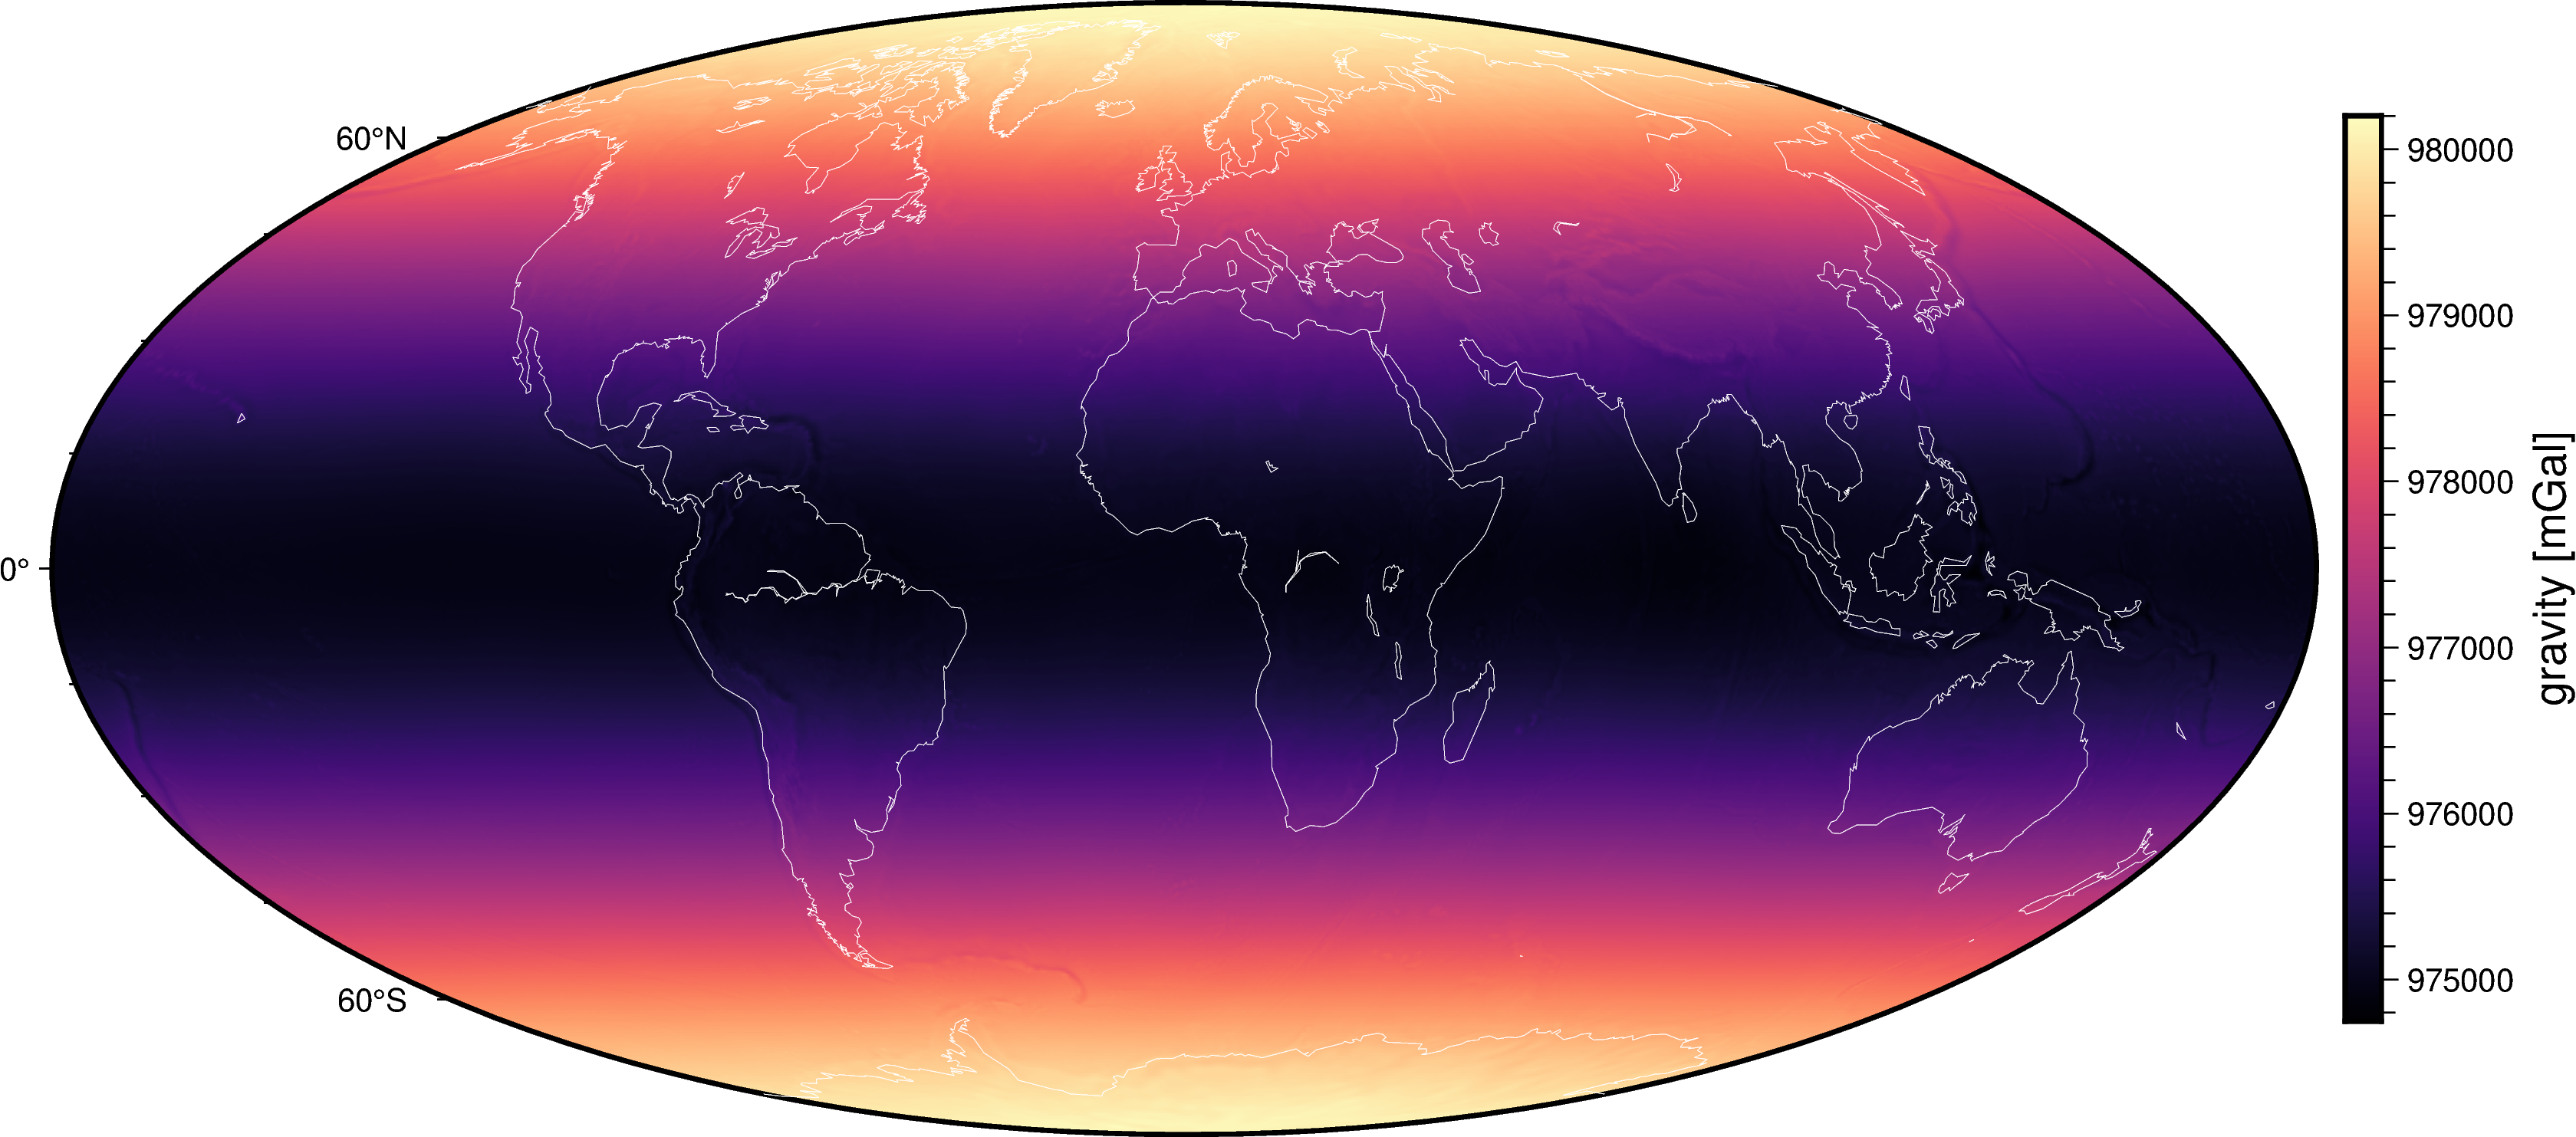

In [11]:
fig = pygmt.Figure()
fig.grdimage(data_reloaded, cmap="magma", projection="W25c")
fig.colorbar(frame='af+l"gravity [mGal]"', position="JCR")
fig.basemap(frame=True)
fig.coast(shorelines="0.1p,white", area_thresh=1e4)
fig.show()